In [10]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
import random
import json
from sklearn.preprocessing import MinMaxScaler

sys.path.append(os.path.abspath('../src/'))
from ActivationFunctions import *
from ModelSelection import *
from NeuralNetwork import *
from MyUtils import *

In [11]:
tr_df = pd.read_csv('../data/monks_csv/monks_tr_1.csv', index_col=0)
len_training = len(tr_df)
val_df = pd.read_csv('../data/monks_csv/monks_ts_1.csv', index_col=0) # test in realtà ma va be
len_validation = len(val_df)
len_dataset = len_training + len_validation
val_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,input_3,input_4,input_5,input_6,output_1
173,2,1,2,1,3,2,0
91,1,2,2,3,2,2,0
105,1,3,1,2,1,2,1
431,3,3,2,3,4,2,1
389,3,3,1,1,3,2,1


In [12]:
def OHE(df):
    OHE = pd.get_dummies(df, columns=['input_'+str(i) for i in range(1, 7)])
    OHE = OHE.set_axis(['output_1'] + ['input_' + str(i) for i in range(1, len(OHE.columns))], axis=1)
    cols = OHE.columns.tolist()
    cols = cols[1:] + cols[:1]
    OHE = OHE[cols]
    return OHE

In [13]:
tr_df_OHE = OHE(tr_df)
tr_df_OHE.head(5)

,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,input_11,input_12,input_13,input_14,input_15,input_16,input_17,output_1
0,True,False,False,True,False,False,True,False,True,False,False,False,False,True,False,True,False,1
1,True,False,False,True,False,False,True,False,True,False,False,False,False,True,False,False,True,1
2,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False,1
3,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,True,1
4,True,False,False,True,False,False,False,True,True,False,False,False,True,False,False,True,False,1


In [14]:
val_df_OHE = OHE(val_df)
val_df_OHE.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,input_11,input_12,input_13,input_14,input_15,input_16,input_17,output_1
173,False,True,False,True,False,False,False,True,True,False,False,False,False,True,False,False,True,0
91,True,False,False,False,True,False,False,True,False,False,True,False,True,False,False,False,True,0
105,True,False,False,False,False,True,True,False,False,True,False,True,False,False,False,False,True,1
431,False,False,True,False,False,True,False,True,False,False,True,False,False,False,True,False,True,1
389,False,False,True,False,False,True,True,False,True,False,False,False,False,True,False,False,True,1


From monk database:

Attribute information:
1. class: 0, 1 
2. a1:    1, 2, 3
3. a2:    1, 2, 3
4. a3:    1, 2
5. a4:    1, 2, 3
6. a5:    1, 2, 3, 4
7. a6:    1, 2
8. Id:    (A unique symbol for each instance)

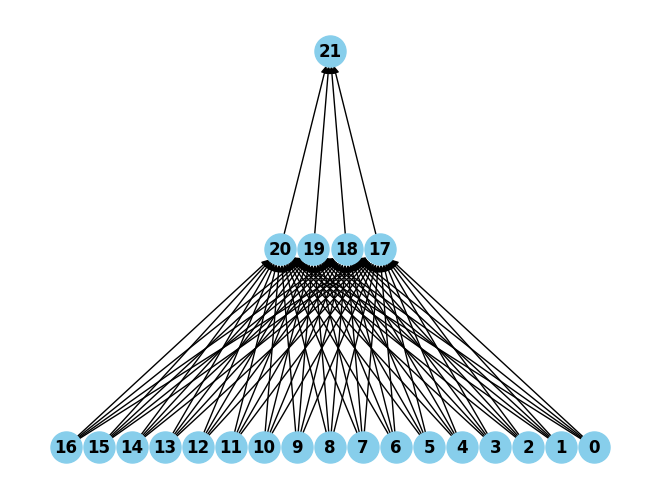

In [15]:
TR_INPUT = len(tr_df_OHE.columns) - 1
TR_OUTPUT = 1
hidden_len = 4
topology = create_stratified_topology([TR_INPUT,hidden_len,TR_OUTPUT], 
                                      [[None,[]]]*TR_INPUT + [['sigmoid', [1]]]*hidden_len + [['sigmoid', [1]]])
NeuralNetwork.display_topology(topology)

In [16]:
tr_df_OHE.values

array([[True, False, False, ..., True, False, 1],
       [True, False, False, ..., False, True, 1],
       [True, False, False, ..., True, False, 1],
       ...,
       [False, False, True, ..., False, True, 1],
       [False, False, True, ..., False, True, 1],
       [False, False, True, ..., False, True, 1]], dtype=object)

In [17]:
training_set = tr_df_OHE.values
validation_set = val_df_OHE.values

print(len(training_set))

124


In [19]:
MS = ModelSelection('../data/gs_data/monk_1_kf.csv')

hyperparam_grid = {
    'learning_rate':[0.3,0.5,0.6],
    'adamax' : [False],
    'alpha_momentum':[0.4,0.5,0.6],
    'lambda_tikhonov':[0],
    'batch_size':[int(len(training_set)/15)],
    'min_epochs': [50],
    'max_epochs':[400, 600],
    'error_increase_tolerance':[np.inf], #don't want early stopping
    'patience':[10], 
    'topology': [str(topology)],
}

MS.grid_searchKF(training_set, hyperparam_grid, {}, 5, 4, False)

tot conf: 18


In [20]:
df = pd.read_csv('../data/gs_data/monk_1_kf.csv')

df['mean_metrics'] = df['mean_metrics'].apply(lambda x: ast.literal_eval(x))
df = df.sort_values(by=['mean_metrics'], ascending=True)

In [21]:
df.drop(['stats', 'topology'], axis=1).head(10)

,adamax,alpha_momentum,batch_size,error_increase_tolerance,lambda_tikhonov,learning_rate,max_epochs,min_epochs,patience,metrics_names,mean_metrics,variance_metrics,mean_best_validation_training_error
1,False,0.6,8,inf,0,0.5,600,50,10,['mean_squared_error'],[0.09317031904419742],[0.0020663940746109104],inf
4,False,0.6,8,inf,0,0.6,600,50,10,['mean_squared_error'],[0.10845041484826537],[0.0056974939148736695],inf
13,False,0.5,8,inf,0,0.6,400,50,10,['mean_squared_error'],[0.12157227664134704],[0.005270853793993829],inf
0,False,0.4,8,inf,0,0.6,400,50,10,['mean_squared_error'],[0.1354195380870038],[0.0031992797343107287],inf
8,False,0.5,8,inf,0,0.3,600,50,10,['mean_squared_error'],[0.13986765294791287],[0.002309431005730152],inf
16,False,0.6,8,inf,0,0.6,400,50,10,['mean_squared_error'],[0.14637663326727307],[0.004780175069025716],inf
7,False,0.4,8,inf,0,0.6,600,50,10,['mean_squared_error'],[0.1775684837199477],[0.00497981848698688],inf
3,False,0.4,8,inf,0,0.5,600,50,10,['mean_squared_error'],[0.17777724318482363],[0.00871980913988829],inf
5,False,0.4,8,inf,0,0.3,400,50,10,['mean_squared_error'],[0.18294476454493888],[0.0007569190216830912],inf
9,False,0.4,8,inf,0,0.5,400,50,10,['mean_squared_error'],[0.19276057734897126],[0.0025587197704287495],inf


In [22]:
training_set = tr_df_OHE.values
validation_set = val_df_OHE.values
metrics = [ErrorFunctions.mean_squared_error, ] #ErrorFunctions.mean_euclidean_error, 

batch_size = int(len(training_set)/15)
error_increase_tolerance = np.inf
lambda_tikhonov = 0
max_epochs = 600
min_epochs = 50
patience = 10

adamax = False

learning_rate = 0.5/batch_size
alpha_momentum = 0.6
lr_decay_tau = 0
eta_tau = lr_decay_tau/100

NN = NeuralNetwork(topology, -0.75, 0.75, True, RANDOM_STATE)
stats = NN.train(training_set, validation_set, 
                 batch_size = batch_size, 
                 max_epochs = max_epochs, 
                 error_increase_tolerance = error_increase_tolerance, 
                 patience = patience, 
                 min_epochs = min_epochs, 
                 lambda_tikhonov = lambda_tikhonov, 
                 metrics = metrics, 
                 
                 learning_rate=learning_rate,
                 alpha_momentum=alpha_momentum,
                 lr_decay_tau=lr_decay_tau,
                 eta_tau=eta_tau,
                 
                 collect_data=True,
                 collect_data_batch=False,
                 verbose=True)

starting values:  {'training_set_len': 124, 'minibatch_size': 8, 'max_epochs': 600, 'retraing_es_error': -1, 'error_increase_tolerance': inf, 'patience': 10, 'min_epochs': 50, 'learning_rate': 0.0625, 'lr_decay_tau': 0, 'eta_tau': 0.0, 'lambda_tikhonov': 0, 'alpha_momentum': 0.6, 'nesterov': False, 'adamax': False, 'adamax_learning_rate': 0.01, 'exp_decay_rates_1': 0.9, 'exp_decay_rates_2': 0.999, 'best_validation_training_error': inf, 'epochs': 0, 'total_train_time': datetime.timedelta(days=-1, seconds=86399, microseconds=999996), 'mean_epoch_train_time': 0, 'units_weights': {20: [], 19: [], 18: [], 17: [], 21: []}, 'units_weights_batch': {20: [], 19: [], 18: [], 17: [], 21: []}, 'training_mean_squared_error': [], 'validation_mean_squared_error': [], 'training_batch_mean_squared_error': [], 'validation_batch_mean_squared_error': []}
[1/600] tr time: 0:00:00.060513 | mean_squared_error: tr=0.25555682770016513 val=0.25735562623421965 | 
[2/600] tr time: 0:00:00.050768 | mean_squared_err

In [23]:
tr_predictions = NN.predict_array(training_set[:,:TR_INPUT])
val_predictions = NN.predict_array(validation_set[:,:TR_INPUT])

In [24]:
pd.options.mode.chained_assignment = None
prediction_col = ['prediction_1']#, 'prediction_2', 'prediction_3']
for col in prediction_col:
    tr_df[prediction_col] = np.array([[1] if x > 0.5 else [0] for x in tr_predictions])
    tr_df[col + '_err'] = (tr_df[col] - tr_df['output_' + col[-1]])**2
    

In [25]:
tr_df['prediction_1_err'].max()

0

In [26]:
tr_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,input_3,input_4,input_5,input_6,output_1,prediction_1,prediction_1_err
56,2,1,2,1,4,2,0,0,0
35,1,3,2,1,2,2,0,0,0
97,3,2,1,1,1,1,1,1,0
17,1,2,1,3,2,1,0,0,0
123,3,3,2,3,4,2,1,1,0


In [27]:
val_df[prediction_col] = val_predictions
for col in prediction_col:
    val_df[prediction_col] = np.array([[1] if x > 0.5 else [0] for x in val_predictions])
    val_df[col + '_err'] = (val_df[col] - val_df['output_' + col[-1]])**2
    

In [28]:
val_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,input_3,input_4,input_5,input_6,output_1,prediction_1,prediction_1_err
173,2,1,2,1,3,2,0,0,0
91,1,2,2,3,2,2,0,0,0
105,1,3,1,2,1,2,1,1,0
431,3,3,2,3,4,2,1,1,0
389,3,3,1,1,3,2,1,1,0


In [29]:
print('training accuracy =', (tr_df['output_1'] == tr_df['prediction_1']).sum() / len(tr_df))
print('validation accuracy =', (val_df['output_1'] == val_df['prediction_1']).sum() / len(val_df))

training accuracy = 1.0
validation accuracy = 1.0


In [30]:
print('misclassified =', (tr_df['output_1'] != tr_df['prediction_1']).sum(), 'su', len(tr_df))
print('misclassified =', (val_df['output_1'] != val_df['prediction_1']).sum(), 'su', len(val_df))

misclassified = 0 su 124
misclassified = 0 su 432


In [31]:
for key in list(stats.keys())[:12]:
    print(key, ':', stats[key])

training_set_len : 124
minibatch_size : 8
max_epochs : 600
retraing_es_error : -1
error_increase_tolerance : inf
patience : 10
min_epochs : 50
learning_rate : 0.0625
lr_decay_tau : 0
eta_tau : 0.0
lambda_tikhonov : 0
alpha_momentum : 0.6


In [32]:
for met in metrics:
    print('last training ' + met.__name__ + ' :', stats['training_' + met.__name__][-1])
    print('last validation ' + met.__name__ + ' :', stats['validation_' + met.__name__][-1])

last training mean_squared_error : 0.0010264172298229967
last validation mean_squared_error : 0.0023168337653713066


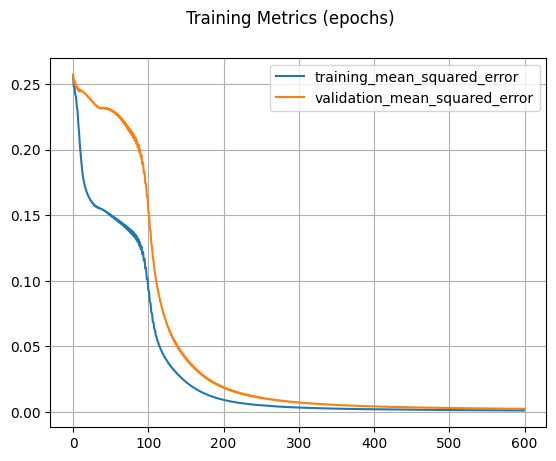

In [33]:
if len(metrics) > 1:
    fig, ax = plt.subplots(1, len(metrics), figsize=(10, 5))
    plt.suptitle('Training Metrics (epochs)')
    for i in range(len(metrics)):
        multy_plot([stats['training_' + metrics[i].__name__], stats['validation_' + metrics[i].__name__]], 
                ['training_' + metrics[i].__name__, 'validation_' + metrics[i].__name__],
                ax=ax[i])
else:
    plt.suptitle('Training Metrics (epochs)')
    multy_plot([stats['training_' + metrics[0].__name__], stats['validation_' + metrics[0].__name__]], 
                ['training_' + metrics[0].__name__, 'validation_' + metrics[0].__name__])

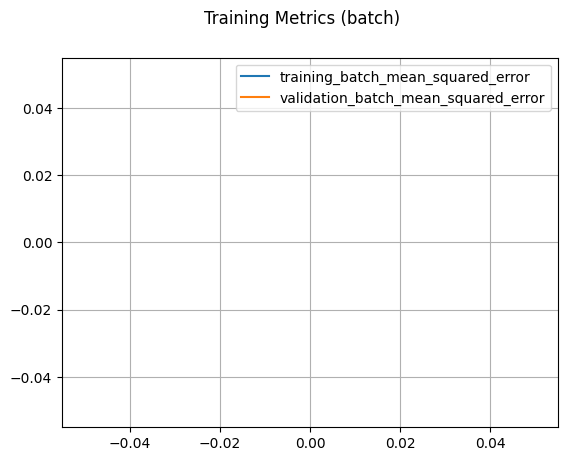

In [34]:
if len(metrics) > 1:
    fig, ax = plt.subplots(1, len(metrics), figsize=(10, 5))
    plt.suptitle('Learning Curve (batch)')
    for i in range(len(metrics)):
        multy_plot([stats['training_batch_' + metrics[i].__name__], stats['validation_batch_' + metrics[i].__name__]], 
                ['training_batch_' + metrics[i].__name__, 'validation_batch_' + metrics[i].__name__],
                ax=ax[i])
    plt.show()
else:
    plt.suptitle('Training Metrics (batch)')
    multy_plot([stats['training_batch_' + metrics[0].__name__], stats['validation_batch_' + metrics[0].__name__]], 
                ['training_batch_' + metrics[0].__name__, 'validation_batch_' + metrics[0].__name__])

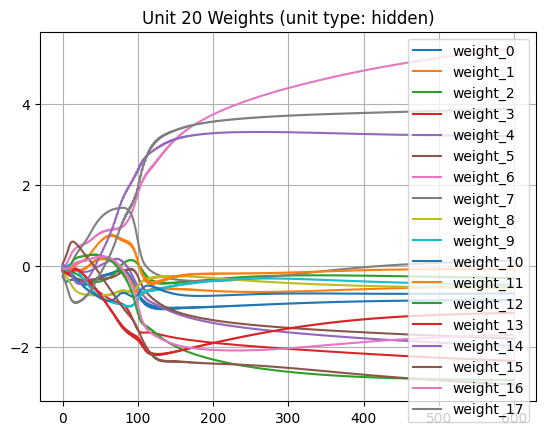

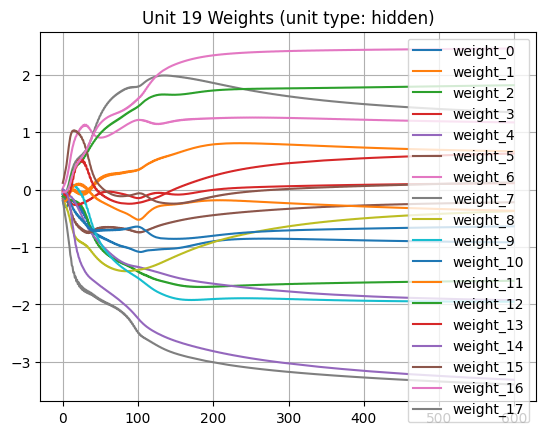

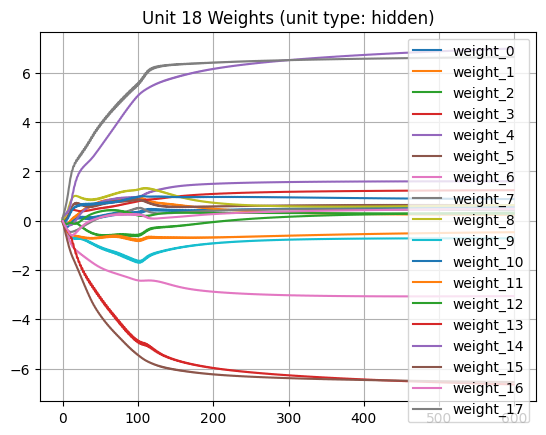

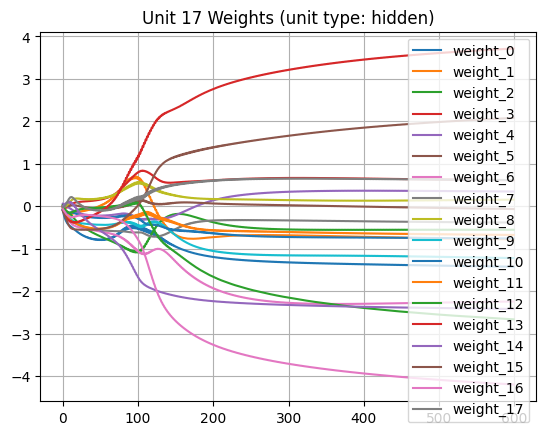

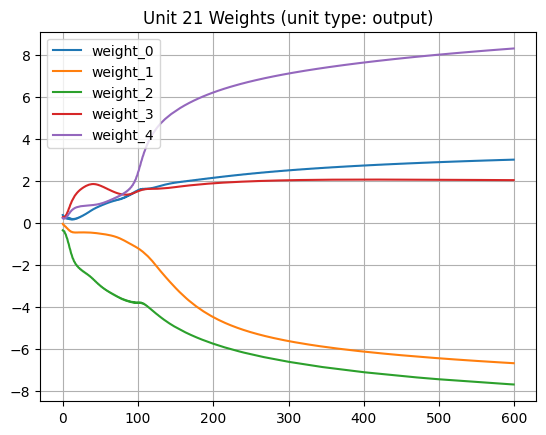

In [35]:
for unit_index in stats['units_weights'].keys():
    vals = np.array(stats['units_weights'][unit_index]).T
    multy_plot(vals, 
               ['weight_' + str(i) for i in range(len(vals))], 
               'Unit ' + str(unit_index) + ' Weights (unit type: ' + NN.neurons[unit_index].type + ')')

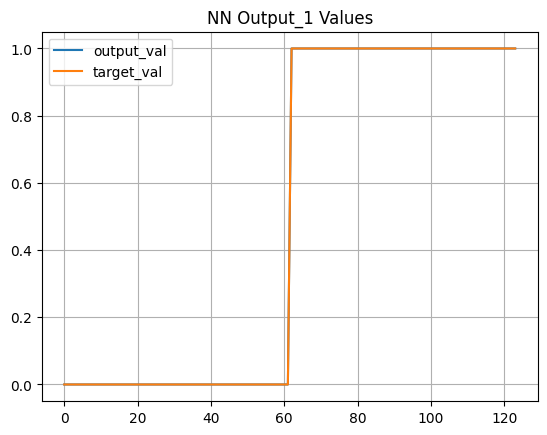

In [36]:
for i in range(TR_OUTPUT):
    sorted_order = training_set[:, TR_INPUT + i].argsort()
    multy_plot([tr_df['prediction_1'].values[sorted_order] , tr_df['output_1'].values[sorted_order]], 
                ['output_val', 'target_val'], 
                'NN Output_' + str(i + 1) +  ' Values')

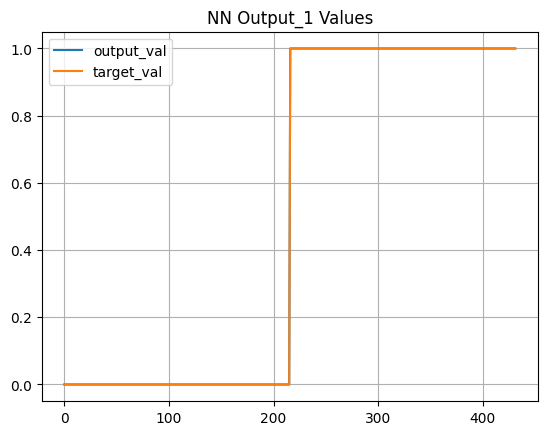

In [37]:
for i in range(TR_OUTPUT):
    sorted_order = validation_set[:, TR_INPUT + i].argsort()
    multy_plot([val_df['prediction_1'].values[sorted_order] , val_df['output_1'].values[sorted_order]], 
                ['output_val', 'target_val'], 
                'NN Output_' + str(i + 1) +  ' Values')